In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

## Homework 5 - Pruning
*Lorenzo Basile*

In [2]:
trainset = torchvision.datasets.MNIST("./data/", train = True, transform=transforms.ToTensor(), download = False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST("./data/", train = False, transform=transforms.ToTensor(), download = False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [3]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))

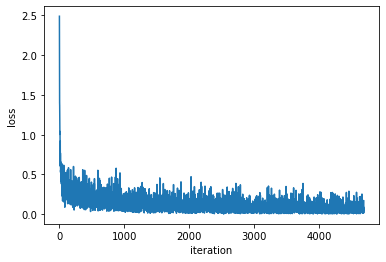

In [4]:
net=NN()
n_epochs=5
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss = torch.nn.CrossEntropyLoss()
losses=[]
for epoch in range(n_epochs):
    print("Epoch: ", epoch+1, '/', n_epochs, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [5]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set: ", correct/len(testset))

Accuracy on test set:  0.9726


The next function is a (minimally) modified version of the one presented during the lab: incremental pruning is allowed by only computing the threshold over nonzero weights of the network.  

In [6]:
def magnitude_pruning(model, pruning_rate, layers_to_prune=["0", "3", "6"]):
    
    params_to_prune = [pars[1] for pars in model.named_parameters() if any([l in pars[0] for l in layers_to_prune])]
    flat = torch.cat([params.abs().flatten() for params in params_to_prune], dim=0)

    flat = flat[flat>0].sort()[0] #only modification to lab code

    position = int(pruning_rate * flat.shape[0])
    thresh = flat[position]

    mask = []
    for pars in model.named_parameters():
        if any([l in pars[0] for l in layers_to_prune]):
            m = torch.where(pars[1].abs() >= thresh, 1, 0)
            mask.append(m)
            pars[1].data *= m
        else:
            mask.append(torch.ones_like(pars[1]))
    return mask

def number_of_ones_in_mask(mask):
    return sum([m.sum().item() for m in mask]) / sum([m.numel() for m in mask])

This implementation does not really *use* the mask to allow iterative pruning and it may happen that weights that are set to $0$ by optimization (not by pruning) are mistakenly considered as pruned. However, I chose to use it because:
- this event should happen very rarely (with probability $\sim 0$);
- it produces very clean code;
- it supports the kind of behaviour displayed in the next cell, which I think is a reasonable way to apply incremental pruning.

In [7]:
mask = magnitude_pruning(net, .2, layers_to_prune=["0", "3", "6"])
print("Number of ones in mask:", number_of_ones_in_mask(mask), "\n")
mask = magnitude_pruning(net, .2, layers_to_prune=["0", "3", "6"])
print("Number of ones in mask:", number_of_ones_in_mask(mask), "\n")
mask = magnitude_pruning(net, .2, layers_to_prune=["0", "3", "6"])
print("Number of ones in mask:", number_of_ones_in_mask(mask), "\n")

Number of ones in mask: 0.8007266946746906 

Number of ones in mask: 0.641308050414443 

Number of ones in mask: 0.5137769198743424 



In [8]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set: ", correct/len(testset))

Accuracy on test set:  0.9665
